In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matspy import spy
import json
from pipeliner.recommendations.transformer import (
    UserItemMatrixTransformer,
    SimilarityTransformer,
)
from pipeliner.recommendations.recommender import SimilarityRecommender

In [55]:
# Create a toy dataset
OVERWRITE = False

NUM_USERS = 12
NUM_ITEMS = 12

# Create arrays for each column
users = np.repeat(np.arange(NUM_USERS), 6)
stacked = np.hstack([np.arange(NUM_ITEMS), np.arange(5)])
strides = np.lib.stride_tricks.sliding_window_view(stacked, 6)
items = strides.reshape(-1)
ratings = np.tile([0.8, 0.4, 0.6, 0.2, 1.0, 0.8], (12, 1))
rating_bias = np.expand_dims((np.arange(12)/100), 1)
ratings = (ratings + rating_bias).reshape(-1)
ratings = np.clip(ratings, 0.0, 1.0)

# Stack arrays to get (user, item, rating) combinations
user_item_ratings_generated = np.column_stack((users, items, ratings)).astype(np.float32)

user_item_ratings_df = pd.DataFrame(
    user_item_ratings_generated, columns=["user_id", "item_id", "rating"]
)
user_item_ratings_df.user_id = user_item_ratings_df.user_id.astype(int).map(
    lambda i: f"U{i + 1:05d}"
)
user_item_ratings_df.item_id = user_item_ratings_df.item_id.astype(int).map(
    lambda i: f"I{i + 1:05d}"
)
if OVERWRITE:
    user_item_ratings_df.to_csv(
        "../../tests/test_data/user_item_ratings_toy.csv", index=False
    )
display(user_item_ratings_df.head(12))

,user_id,item_id,rating
0,U00001,I00001,0.80
1,U00001,I00002,0.40
2,U00001,I00003,0.60
3,U00001,I00004,0.20
4,U00001,I00005,1.00
5,U00001,I00006,0.80
6,U00002,I00002,0.81
7,U00002,I00003,0.41
8,U00002,I00004,0.61
9,U00002,I00005,0.21


In [56]:
users = user_item_ratings_df.user_id.unique()
items = user_item_ratings_df.item_id.unique()
user_item_matrix_transformer = UserItemMatrixTransformer()
user_item_matrix = user_item_matrix_transformer.transform(
    user_item_ratings_generated
)
user_item_matrix_df = pd.DataFrame(
    user_item_matrix, index=users, columns=items
).astype(np.float32)
user_item_matrix_df.index.name = "user_id"
display(user_item_matrix_df)

if OVERWRITE:
    user_item_matrix_df.to_csv(
        "../../tests/test_data/user_item_matrix_toy.csv", index=True
    )

user_similarity_matrix_transformer = SimilarityTransformer()
user_similarity_matrix = user_similarity_matrix_transformer.transform(user_item_matrix)
user_similarity_matrix_df = pd.DataFrame(
    user_similarity_matrix, index=users, columns=users
).astype(np.float32)
user_similarity_matrix_df.index.name = "user_id"
display(user_similarity_matrix_df)

if OVERWRITE:
    user_similarity_matrix_df.to_csv(
        "../../tests/test_data/user_similarity_matrix_toy.csv", index=True
    )

item_similarity_matrix_transformer = SimilarityTransformer()
item_similarity_matrix = item_similarity_matrix_transformer.transform(
    user_item_matrix.T
)
item_similarity_matrix_df = pd.DataFrame(
    item_similarity_matrix, index=items, columns=items
).astype(np.float32)
item_similarity_matrix_df.index.name = "item_id"
display(item_similarity_matrix_df)

if OVERWRITE:
    item_similarity_matrix_df.to_csv(
        "../../tests/test_data/item_similarity_matrix_toy.csv", index=True
    )

,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,I00011,I00012
user_id,,,,,,,,,,,,
U00001,0.80,0.40,0.60,0.20,1.00,0.80,0.00,0.00,0.00,0.00,0.00,0.00
U00002,0.00,0.81,0.41,0.61,0.21,1.00,0.81,0.00,0.00,0.00,0.00,0.00
U00003,0.00,0.00,0.82,0.42,0.62,0.22,1.00,0.82,0.00,0.00,0.00,0.00
U00004,0.00,0.00,0.00,0.83,0.43,0.63,0.23,1.00,0.83,0.00,0.00,0.00
U00005,0.00,0.00,0.00,0.00,0.84,0.44,0.64,0.24,1.00,0.84,0.00,0.00
U00006,0.00,0.00,0.00,0.00,0.00,0.85,0.45,0.65,0.25,1.00,0.85,0.00
U00007,0.00,0.00,0.00,0.00,0.00,0.00,0.86,0.46,0.66,0.26,1.00,0.86
U00008,0.87,0.00,0.00,0.00,0.00,0.00,0.00,0.87,0.47,0.67,0.27,1.00
U00009,1.00,0.88,0.00,0.00,0.00,0.00,0.00,0.00,0.88,0.48,0.68,0.28


,U00001,U00002,U00003,U00004,U00005,U00006,U00007,U00008,U00009,U00010,U00011,U00012
user_id,,,,,,,,,,,,
U00001,1.000000,0.593422,0.473685,0.376071,0.403558,0.227984,0.000000,0.228862,0.375167,0.376090,0.466428,0.629074
U00002,0.593422,1.000000,0.599157,0.478312,0.380428,0.403195,0.229023,0.000000,0.229859,0.375247,0.380240,0.471035
U00003,0.473685,0.599157,1.000000,0.604672,0.482801,0.384623,0.402779,0.230013,0.000000,0.230808,0.375268,0.384238
U00004,0.376071,0.478312,0.604672,1.000000,0.609972,0.487156,0.388662,0.402315,0.230955,0.000000,0.231711,0.375235
U00005,0.403558,0.380428,0.482801,0.609972,1.000000,0.615067,0.491380,0.392551,0.401804,0.231852,0.000000,0.232571
U00006,0.227984,0.403195,0.384623,0.487156,0.615067,1.000000,0.619961,0.495476,0.396293,0.401251,0.232705,0.000000
U00007,0.000000,0.229023,0.402779,0.388662,0.491380,0.619961,1.000000,0.624663,0.499449,0.399894,0.400659,0.233516
U00008,0.228862,0.000000,0.230013,0.402315,0.392551,0.495476,0.624663,1.000000,0.629179,0.503301,0.403359,0.400029
U00009,0.375167,0.229859,0.000000,0.230955,0.401804,0.396293,0.499449,0.629179,1.000000,0.633514,0.507036,0.406692


,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,I00011,I00012
item_id,,,,,,,,,,,,
I00001,1.000000,0.642846,0.505271,0.411597,0.396416,0.205515,0.000000,0.238351,0.401951,0.407988,0.516017,0.655640
I00002,0.642846,1.000000,0.632022,0.495627,0.384169,0.365501,0.210151,0.000000,0.243258,0.408280,0.418528,0.528675
I00003,0.505271,0.632022,1.000000,0.623209,0.473609,0.351557,0.374707,0.216567,0.000000,0.250214,0.417999,0.432617
I00004,0.411597,0.495627,0.623209,1.000000,0.595231,0.455078,0.359464,0.378332,0.219780,0.000000,0.253462,0.421489
I00005,0.396416,0.384169,0.473609,0.595231,1.000000,0.581411,0.459660,0.363750,0.378209,0.220812,0.000000,0.254197
I00006,0.205515,0.365501,0.351557,0.455078,0.581411,1.000000,0.606750,0.479805,0.380324,0.390818,0.229298,0.000000
I00007,0.000000,0.210151,0.374707,0.359464,0.459660,0.606750,1.000000,0.612061,0.484154,0.384348,0.390490,0.230213
I00008,0.238351,0.000000,0.216567,0.378332,0.363750,0.479805,0.612061,1.000000,0.617166,0.488373,0.388224,0.390115
I00009,0.401951,0.243258,0.000000,0.219780,0.378209,0.380324,0.484154,0.617166,1.000000,0.622071,0.492465,0.391956


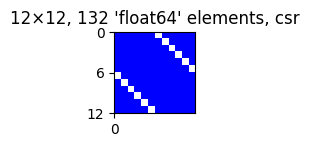

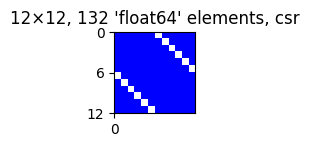

In [57]:
spy(sp.sparse.csr_matrix(item_similarity_matrix))
spy(sp.sparse.csr_matrix(user_similarity_matrix))

In [58]:
item_ids = user_item_matrix_df.columns

item_encoder = LabelEncoder()
item_ids_encoded = item_encoder.fit_transform(item_ids)

similarity_rec = SimilarityRecommender(10)
similarity_rec.fit(item_similarity_matrix)
item_recs = similarity_rec.recommend(item_ids_encoded)

results = [item_encoder.inverse_transform(item).tolist() for item in item_recs]
similarity_recommendations_toy = {item_id: result for item_id, result in zip(item_ids, results)}

if OVERWRITE:
    with open("../../tests/test_data/similarity_recommendations_toy.json", "w") as f:
        f.write(json.dumps(similarity_recommendations_toy, indent=4))

    item_probs = similarity_rec.predict_proba(item_ids_encoded).toarray().astype(np.float32).round(6)
    np.save("../../tests/test_data/similarity_recommendations_toy_probs.npy", item_probs)